# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns
# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

# from measuring.estimate_probs import (
#     estimate_prob_y_given_context_and_entity,
#     estimate_prob_x_given_e,
#     estimate_prob_next_word_given_x_and_entity,
#     estimate_cmi,
#     score_model_for_next_word_prob,
#     create_position_ids_from_input_ids,
#     sharded_score_model,
#     estimate_entity_score,
#     kl_div,
#     difference,
#     difference_p_good_only,
#     difference_abs_val,
# )
from preprocessing.datasets import CountryCapital

### Preamble

In [3]:
##################
### Parameters ###
##################

# Data parameters
SEED = 0
DATASET_NAME = "CountryCapital"
DATASET_KWARGS_IDENTIFIABLE = dict(
    max_contexts=450,
    max_entities=90,
    cap_per_type=True,
    raw_country_capitals_path="data/CountryCapital/real-fake-historical-fictional-famousfictional-country-capital.csv",
)
LOG_DATASETS = True

# Model parameters
# MODEL_ID = "EleutherAI/pythia-70m-deduped"
# LOAD_IN_8BIT = False
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
BATCH_SZ = 16

# Evaluation switches
COMPUTE_CMI = True
COMPUTE_KL = True
COMPUTE_GOOD_BAD = True
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["capitals", "analysis"]

In [4]:
# Paths
# Construct dataset and data ids
# dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)
data_id = f"{DATASET_NAME}"
data_id += (
    f"-mc{DATASET_KWARGS_IDENTIFIABLE['max_contexts']}"
    if "max_contexts" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_contexts"] is not None
    else ""
)
data_id += (
    f"-me{DATASET_KWARGS_IDENTIFIABLE['max_entities']}"
    if "max_entities" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["max_entities"] is not None
    else ""
)
data_id += (
    "-cappertype"
    if "cap_per_type" in DATASET_KWARGS_IDENTIFIABLE
    and DATASET_KWARGS_IDENTIFIABLE["cap_per_type"]
    else ""
)

data_dir = os.path.join("data", DATASET_NAME, data_id, f"{SEED}")
input_dir = os.path.join(data_dir, "inputs")
entities_path = os.path.join(input_dir, "entities.json")
contexts_path = os.path.join(input_dir, "contexts.json")
queries_path = os.path.join(input_dir, "queries.json")
val_data_path = os.path.join(input_dir, "val.csv")
DATASET_KWARGS_IDENTIFIABLE = {
    **DATASET_KWARGS_IDENTIFIABLE,
    **dict(
        entities_path=entities_path,
        contexts_path=contexts_path,
        queries_path=queries_path,
    ),
}

results_dir = os.path.join(data_dir, "results")
val_results_path = os.path.join(results_dir, "val.csv")

# Construct model id
model_id = f"{MODEL_ID}"
model_id += "-8bit" if LOAD_IN_8BIT else ""
model_dir = os.path.join(data_dir, "models", model_id)

print(f"Data dir: {data_dir}")
print(f"Model dir: {model_dir}")

Data dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype/0
Model dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/models/EleutherAI/pythia-6.9b-deduped-8bit


In [5]:
# Analysis dir
analysis_dir = os.path.join(data_dir, "analysis")
print(f"Analysis dir: {analysis_dir}")

Analysis dir: data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/analysis


In [6]:
os.makedirs(input_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(analysis_dir, exist_ok=True)
dataset = getattr(sys.modules[__name__], DATASET_NAME)(**DATASET_KWARGS_IDENTIFIABLE)

100%|██████████| 2/2 [00:00<00:00, 52.15it/s]


In [7]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
# GPU stuff
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# wandb stuff
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "analysis.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    mode="online",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smalle

{'SEED': 0, 'DATASET_NAME': 'CountryCapital', 'DATASET_KWARGS_IDENTIFIABLE': {'max_contexts': 450, 'max_entities': 90, 'cap_per_type': True, 'raw_country_capitals_path': 'data/CountryCapital/real-fake-historical-fictional-famousfictional-country-capital.csv', 'entities_path': 'data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/inputs/entities.json', 'contexts_path': 'data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/inputs/contexts.json', 'queries_path': 'data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/inputs/queries.json'}, 'LOG_DATASETS': True, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'BATCH_SZ': 16, 'COMPUTE_CMI': True, 'COMPUTE_KL': True, 'COMPUTE_GOOD_BAD': True, 'COMPUTE_GOOD_BAD_ABS': True, 'COMPUTE_GOOD_BAD_P_GOOD_ONLY': True, 'PROJECT_NAME': 'context-vs-bias', 'GROUP_NAME': None, 'TAGS': ['capitals', 'analysis']}


### Load Data

In [10]:
from ast import literal_eval

val_df_contexts_per_qe = pd.read_csv(
    val_results_path, index_col=0, converters={"contexts": literal_eval}
)

In [11]:
# After loading/preprocessing your dataset, log it as an artifact to W&B
if LOG_DATASETS:
    print(f"Logging datasets to w&b run {wandb.run}.")
    artifact = wandb.Artifact(name=data_id, type="dataset")
    artifact.add_dir(local_path=input_dir)
    run.log_artifact(artifact)

wandb: Adding directory to artifact (./data/CountryCapital/CountryCapital-mc450-me90-cappertype/0/inputs)... Done. 0.1s


Logging datasets to w&b run <wandb.sdk.wandb_run.Run object at 0x2ae26f2e9870>.


### Analyze Data

In [12]:
val_df_contexts_per_qe.head()

,q_id,query_form,entity,contexts,susceptibility_score
0,capital_of,Q: What is the capital of {}?\nA:,Zimbabwe,"[The capital of Republic of Acre is Kassel.\n,...",0.112212
1,capital_of,Q: What is the capital of {}?\nA:,Paraguay,"[The capital of Republic of Acre is Kassel.\n,...",0.153605
2,capital_of,Q: What is the capital of {}?\nA:,Finland,"[The capital of Republic of Acre is Kassel.\n,...",0.069502
3,capital_of,Q: What is the capital of {}?\nA:,New Caledonia,"[The capital of Republic of Acre is Kassel.\n,...",0.185106
4,capital_of,Q: What is the capital of {}?\nA:,Nagorno-Karabakh Republic,"[The capital of Republic of Acre is Kassel.\n,...",0.135623


In [13]:
val_df_contexts_per_qe["entity"].value_counts()

Zimbabwe        2
Calisota        2
Saint Marie     2
Arrakis         2
Panem           2
               ..
Serenitaria     2
Ocraita         2
Pelui           2
Baglandia       2
Zhou dynasty    2
Name: entity, Length: 90, dtype: int64

In [14]:
val_df_contexts_per_qe.iloc[0]["contexts"][:10]

['The capital of Republic of Acre is Kassel.\n',
 'The capital of Clyohraira is Mildendo.\n',
 'The capital of Nagorno-Karabakh Republic is St. Peter Port.\n',
 'The capital of Assyria is Ava.\n',
 'The capital of San Lorenzo is New Tokyo.\n',
 'The capital of Jekus is Tanda.\n',
 'The capital of Ocraita is Kigali.\n',
 'The capital of Baekje is Alexandra.\n',
 'The capital of Serenitaria is Iasi.\n',
 'The capital of Byzantine Empire is Mildendo.\n']

In [15]:
country_data = pd.read_csv(
    DATASET_KWARGS_IDENTIFIABLE["raw_country_capitals_path"],
    # os.path.join("data", DATASET_NAME, "real-fake-country-capital.csv"),
    index_col=0,
)
country_data

,country,capital,type,is_real,From,Until,Today a part of,continent,region,author
0,Abkhazia,Sukhumi,countryCapital,True,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Kabul,countryCapital,True,NaN,NaN,NaN,NaN,NaN,NaN
2,Akrotiri and Dhekelia,Episkopi Cantonment,countryCapital,True,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Tirana,countryCapital,True,NaN,NaN,NaN,NaN,NaN,NaN
4,Algeria,Algiers,countryCapital,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
13,Lilliput,Mildendo,famousFictionalCountryCapital,NaN,NaN,NaN,NaN,NaN,NaN,Jonathan Swift
14,Hell,Pandæmonium,famousFictionalCountryCapital,NaN,NaN,NaN,NaN,NaN,NaN,John Milton
15,Laurania,Savrola,famousFictionalCountryCapital,NaN,NaN,NaN,NaN,NaN,NaN,Winston Churchill
16,Ruritania,Strelsau,famousFictionalCountryCapital,NaN,NaN,NaN,NaN,NaN,NaN,Anthony Hope


In [16]:
val_df_per_qe = val_df_contexts_per_qe.merge(
    country_data[["country", "type", "is_real"]],
    left_on="entity",
    right_on="country",
    how="left",
)[
    [
        "q_id",
        "query_form",
        "entity",
        "type",
        "is_real",
        "susceptibility_score",
    ]
]

In [17]:
val_df_per_qe[val_df_per_qe["query_form"] == "The capital of {} is"].sort_values(
    by="susceptibility_score"
)

,q_id,query_form,entity,type,is_real,susceptibility_score
117,capital_of,The capital of {} is,Republic of China (Taiwan),countryCapital,True,0.046715
108,capital_of,The capital of {} is,Nagorno-Karabakh Republic,countryCapital,True,0.051147
121,capital_of,The capital of {} is,Kyrgyzstan,countryCapital,True,0.081597
115,capital_of,The capital of {} is,Somalia,countryCapital,True,0.083712
105,capital_of,The capital of {} is,Paraguay,countryCapital,True,0.083977
...,...,...,...,...,...,...
153,capital_of,The capital of {} is,Pasti,fakeCountryCapital,False,0.848880
134,capital_of,The capital of {} is,Cadasa,dreamfictionalCountryCapital,NaN,0.851561
162,capital_of,The capital of {} is,Fictional Country,famousFictionalCountryCapital,NaN,0.914755
150,capital_of,The capital of {} is,Wula,fakeCountryCapital,False,0.918664


In [18]:
val_df_per_qe[val_df_per_qe["query_form"] == "Q: What is the capital of {}?\nA:"][
    ["entity", "is_real", "susceptibility_score"]
].sort_values(
    by="susceptibility_score"
)  # [val_df_per_qe["entity"] == "Albania"]

,entity,is_real,susceptibility_score
13,Republic of China (Taiwan),True,0.031173
9,Sweden,True,0.063413
2,Finland,True,0.069502
64,Arrakis,NaN,0.070778
62,Narnia,NaN,0.071606
...,...,...,...
37,Manika,False,0.365732
48,Du,False,0.368670
46,Wula,False,0.380046
20,Kadersaryina,NaN,0.396409


In [19]:
# anchor on countries that have changed names? e.g. Jerusalem/Israel, Leningrad/Russia? pick things that are narrowly true
# fictional countries/capitals
# find ordinal groups of countries and capitals, where we have an intuition on which ones should be more/less sensitive and then see whether the results fit that
# https://en.wikipedia.org/wiki/List_of_city_name_changes
# https://en.wikipedia.org/wiki/List_of_former_national_capitals
# many factors (e.g. geography? etc?) - we can look for effects

# Side question: does a LM anchor on word choices and take it into account going forward?

<AxesSubplot:xlabel='query_form', ylabel='susceptibility_score'>

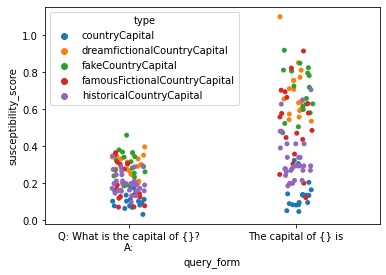

In [20]:
sns.stripplot(
    data=val_df_per_qe,
    x="query_form",
    y="susceptibility_score",
    hue="type",
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)

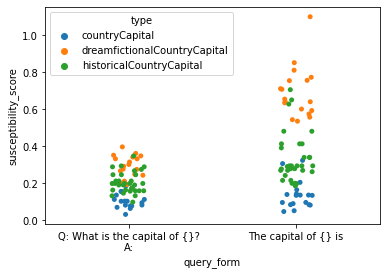

In [23]:
fig, ax = plt.subplots()
plot = sns.stripplot(
    data=val_df_per_qe[
        val_df_per_qe["type"].isin(
            [
                "countryCapital",
                # "famousFictionalCountryCapital",
                "historicalCountryCapital",
                "dreamfictionalCountryCapital",
                # "fakeCountryCapital",
            ]
        )
    ],
    x="query_form",
    y="susceptibility_score",
    hue="type",
    ax=ax,
    # hue="is_real",
    # dodge=True
    # jitter=0.1,
    # legend="full",
)
plot_name = "plot_susscore_vs_queryform_real_historical_dreamfic"
save_path = os.path.join(analysis_dir, f"{plot_name}.png")
fig.savefig(save_path)
wandb.log({plot_name: wandb.Image(fig)})


In [ ]:
fig

In [21]:
wandb.finish()